In [1]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

In [2]:
def pca_reduce(data, n_components):
    """
    使用PCA对数据进行降维。

    参数:
    data: numpy array, 原始数据
    n_components: int, 降维后的维度

    返回:
    降维后的数据
    """
    # 步骤1：对所有样本进行去中心化处理
    mean_vector = np.mean(data, axis=0)
    data_centered = data - mean_vector

    # 步骤2：计算样本的协方差矩阵
    cov_matrix = np.cov(data_centered, rowvar=False)

    # 步骤3：对协方差矩阵进行特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # 步骤4：选择最大的n_components个特征值对应的特征向量构成投影矩阵
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[:n_components]
    projection_matrix = eigenvectors[:, top_k_indices]

    # 步骤5：输出降维后的样本集
    reduced_data = np.dot(data_centered, projection_matrix)

    return reduced_data


def init_centroids(X, k):
    # 从数据集X中随机初始化k个质心
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    for i in range(k):
        centroids[i, :] = X[idx[i], :]
    return centroids


def find_closest_centroids(X, centroids):
    # 为数据集X中的每个数据点找到最近的质心
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m, dtype=int)

    for i in range(m):
        min_dist = float('inf')
        for j in range(k):
            dist = np.sum((X[i, :] - centroids[j]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    return idx


def compute_centroids(X, idx, k):
    # 计算每个质心的新位置，即分配给每个质心的数据点的均值
    m, n = X.shape
    centroids = np.zeros((k, n))
    for i in range(k):
        indices = np.where(idx == i)[0]
        if len(indices) > 0:
            centroids[i, :] = np.mean(X[indices, :], axis=0)
    return centroids


def run_k_means(X, initial_centroids, max_iters):
    # 运行K-means算法，指定迭代次数或直到收敛
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m, dtype=int)
    centroids = initial_centroids.copy()
    err = np.zeros(max_iters)

    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        _centroids = compute_centroids(X, idx, k)
        err[i] = np.sqrt(np.sum((centroids - _centroids) ** 2))
        if err[i] < 0.001:
            err = err[:i + 1]
            break
        centroids = _centroids

    return idx, centroids, err


def bayesian_em_gmm_hmm(X, u_prior, sigma_prior, alpha_prior, transmat_prior, startprob_prior, k, max_iters):
    # 转换为高精度浮点数
    X = np.asarray(X, dtype=np.float64)
    u_prior = np.asarray(u_prior, dtype=np.float64)
    sigma_prior = np.asarray(sigma_prior, dtype=np.float64)
    
    #采用贝叶斯EM算法进行估计
    m, n = X.shape
    p = np.zeros((m, k))
    lld = 0
    _lld = 0
    llds = np.zeros(max_iters)

    # 初始化参数为先验参数
    u = u_prior.copy()
    sigma = sigma_prior.copy()
    alpha = alpha_prior.copy()
    transmat = transmat_prior.copy()
    startprob = startprob_prior.copy()

    for it in range(max_iters):
        for j in range(m):
            for i in range(k):
                p[j, i] = alpha[i] * np.exp(-0.5 * np.dot(np.dot((X[j] - u[i]), np.linalg.inv(sigma[i])), (X[j] - u[i]).T)) / (np.sqrt((2 * np.pi) ** n * np.linalg.det(sigma[i])))
        
        # 归一化得到各混合成分的后验概率
        for j in range(m):
            p[j, :] = p[j, :] / np.sum(p[j, :])

        # 更新参数，结合先验信息
        for i in range(k):
            u[i] = np.zeros(n)
            for j in range(m):
                u[i] = u[i] + p[j, i] * X[j]
            u[i] = (u[i] + 1000 * u_prior[i]) / (np.sum(p[:, i]) + 1000)
        
        for i in range(k):
            sigma[i] = np.zeros((n, n))
            for j in range(m):
                sigma[i] = sigma[i] + p[j, i] * np.outer((X[j] - u[i]), (X[j] - u[i]))
            sigma[i] = (sigma[i] + 1000 * sigma_prior[i]) / (np.sum(p[:, i]) + 1000)

        for i in range(k):
            alpha[i] = (np.sum(p[:, i]) + 1000 * alpha_prior[i]) / (m + 1000 * np.sum(alpha_prior))
            
        #print(f"Iteration {it}: u = {u}, sigma = {sigma}, alpha = {alpha}")
        
        # 更新隐马尔可夫模型的参数
        model = GaussianHMM(n_components=k, covariance_type='full', n_iter=1, init_params="")
        model.startprob_ = startprob
        model.transmat_ = transmat
        model.means_ = u
        model.covars_ = sigma
        model.fit(X)
        transmat = model.transmat_
        startprob = model.startprob_

        _C = np.argmax(p, axis=1)
        _lld = 0
        for i in range(k):
            p[:, i] = p[:, i] * alpha[i]
        for j in range(m):
            _lld = _lld + np.log(np.sum(p[j, :]))
        if abs(lld - _lld) < 0.0001:
            return _C, it, llds, u, transmat, startprob
        lld = _lld
        llds[it] = abs(lld - _lld)
    
    return _C, it, llds, u, transmat, startprob

In [3]:
# 读取数据
path = 'datainfo2.txt'
data = pd.read_csv(path, header=None, names=['WY1', 'QF1X', 'QF1Y', 'YL1Y', 'DZ1', 'ND1', 'YL1W'], usecols=np.arange(7))
print(data.min())
print(data.max())

WY1    -35.153667
QF1X    -0.163793
QF1Y    -0.361233
YL1Y   -17.400067
DZ1      0.000023
ND1     -1.938007
YL1W     8.666667
dtype: float64
WY1      -3.038000
QF1X      0.056033
QF1Y      0.031300
YL1Y    183.333333
DZ1       0.000220
ND1       6.595414
YL1W     36.900002
dtype: float64


In [4]:
# 标准化数据
data2 = (data - data.min()) / (data.max() - data.min())
X = data2.values
k = 5
m, n = X.shape
# 打印数据信息
print(data2.head())
print(X.shape)
print(data2.max())

        WY1      QF1X      QF1Y      YL1Y       DZ1       ND1      YL1W
0  0.994660  0.834263  0.995329  0.687811  0.013206  0.017534  0.003542
1  0.995828  0.840480  0.992272  0.691714  0.019301  0.013734  0.001181
2  0.996367  0.831220  0.995810  0.690634  0.011174  0.012066  0.001181
3  0.996928  0.832444  0.998047  0.691963  0.026919  0.010819  0.001181
4  0.997260  0.826985  0.997707  0.692129  0.009142  0.010586  0.000000
(5275, 7)
WY1     1.0
QF1X    1.0
QF1Y    1.0
YL1Y    1.0
DZ1     1.0
ND1     1.0
YL1W    1.0
dtype: float64


In [5]:
# 使用PCA进行降维
#observations_pca = pca_reduce(X, 5)
observations_pca = X

In [6]:
# 运行K-means
initial_centroids = init_centroids(observations_pca, k)
idx, centroids, err = run_k_means(observations_pca, initial_centroids, 200)

In [7]:
# 打印Kmeans结果
for i in range(k):
    indices = np.where(idx == i)
    print('{}:{}'.format(i + 1, len(indices[0])))
print(err)
print(centroids)

1:450
2:1784
3:963
4:1033
5:1045
[0.24510067 0.09042368 0.05118035 0.04427399 0.03772987 0.03100455
 0.02636202 0.02312013 0.02821208 0.02370998 0.01816572 0.01263165
 0.00534603 0.00474562 0.00566719 0.00869661 0.00677237 0.00704683
 0.00753674 0.00808111 0.00697878 0.00586277 0.00716632 0.00626723
 0.00460171 0.00513183 0.00451001 0.00438294 0.00406006 0.00425926
 0.00447374 0.003303   0.0017216  0.00090069]
[[0.75694995 0.74256083 0.85383278 0.75756062 0.10519066 0.27669965
  0.26548976]
 [0.25749329 0.62916206 0.53834723 0.41607218 0.30518577 0.77969086
  0.76698079]
 [0.12429555 0.5298132  0.45556344 0.25928869 0.40039686 0.85761091
  0.86475459]
 [0.54173764 0.64704289 0.74133628 0.70088737 0.15972471 0.47065623
  0.47508314]
 [0.40504028 0.67408422 0.61887509 0.51200556 0.22191664 0.64696028
  0.63861584]]


In [8]:
# 初始化GMM-HMM模型参数
sigma = [np.cov(observations_pca[np.where(idx == i)].T) if len(np.where(idx == i)[0]) > 0 else np.cov(observations_pca.T) for i in range(k)]
alpha = [0.20, 0.20, 0.20, 0.20, 0.20]
transmat = np.ones((k, k)) / k
startprob = np.ones(k) / k

In [9]:
# 使用K-means结果作为GMM-HMM的初始参数进行贝叶斯EM算法估计
C, iters, llds, u, transmat, startprob = bayesian_em_gmm_hmm(observations_pca, centroids, sigma, alpha, transmat, startprob, k, max_iters=100)

In [10]:
print('混合模型结果')
print(llds[step:iters])
print('迭代{}次'. format(iters+1))
print('前10个样本的分类结果{}'.format(C[:10]))
print('gmm-hmm中心{}'.format(u))

混合模型结果


NameError: name 'step' is not defined

C:\Users\lyr\AppData\Local\Temp\ipykernel_4064\1441556825.py:7: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min(y),max(y))
D:\softwareinstall\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\softwareinstall\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\softwareinstall\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\softwareinstall\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.

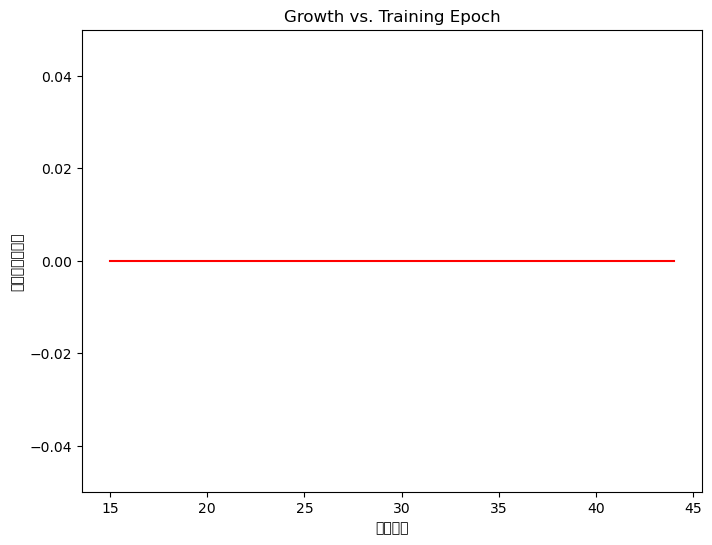

In [104]:
step = 15
x = np.linspace(step, iters, iters-step)
y = llds[step:iters]
# y = list(np.array(y) * 100) # 每个元素乘100
fig, ax = plt.subplots(figsize=(8,6)) # fig绘图窗口，ax坐标系
ax.plot(x, y, 'r', label='Prediction')
ax.set_ylim(min(y),max(y))
ax.set_xlabel('迭代次数')
ax.set_ylabel('似然函数增长量')
ax.set_title('Growth vs. Training Epoch')
plt.show()

In [21]:
for i in range(k):
    indices = np.where(C == i)
    print('{}: {}'.format(i + 1, len(indices[0])))

1: 1921
2: 1049
3: 970
4: 881
5: 454


In [27]:
# 将隐状态结果添加为新的一列
data['Labelhmm'] = C+1

# 保存带有隐状态结果的新数据到CSV文件中
data.to_csv('datainfohmm2.csv', index=False)